In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load your dataset
df = pd.read_csv("./DATA/data4day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# Encode categories
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# Features and target
features = ['CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize
scaler = MinMaxScaler()
df[features + [target]] = scaler.fit_transform(df[features + [target]])

# Create sequences
def create_sequences(data, target_index, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # all features except target
        y.append(data[i+seq_length, target_index])  # predict next
    return np.array(X), np.array(y)

data = df[features + [target]].values
X, y = create_sequences(data, -1, seq_length=5)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=X.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
for epoch in range(10):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_X).squeeze()
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Predict
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().numpy()

# Inverse scale for interpretation
rescaled = scaler.inverse_transform(
    np.hstack([X.reshape(X.shape[0], -1)[:, :len(features)], predictions.reshape(-1, 1)])
)

# Output result
output_df = pd.DataFrame({
    'Predicted_Processing_Time': rescaled[:, -1],
    'Actual_Processing_Time': scaler.inverse_transform(data[5:])[:, -1]
})

print(output_df.head(20))


Epoch 1: Loss = 0.0047
Epoch 2: Loss = 0.0017
Epoch 3: Loss = 0.0260
Epoch 4: Loss = 0.0110
Epoch 5: Loss = 0.0021
Epoch 6: Loss = 0.0048
Epoch 7: Loss = 0.0051
Epoch 8: Loss = 0.0011
Epoch 9: Loss = 0.0014
Epoch 10: Loss = 0.0006
    Predicted_Processing_Time  Actual_Processing_Time
0                    2.991733                4.566667
1                    2.984578                4.150000
2                    2.982290                1.350000
3                    2.984129               11.433333
4                    2.983692                0.175000
5                    2.988738                5.280952
6                    2.907811                1.561111
7                    2.832053                0.916667
8                    2.793155                1.866667
9                    2.786630                1.562281
10                   2.730604                2.840476
11                   2.609183                7.950000
12                   2.550436                2.350000
13           

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv("data1day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# Create binary classification target
df['performance_issue'] = (df['AVG_PROCESSING_TIME_MINUTES'] > 10).astype(int)

# Encode categorical variables
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# Define input features (without station)
features = ['CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT']
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'performance_issue'

# Normalize all features and regression target
scaler = MinMaxScaler()
df[features + [target_reg]] = scaler.fit_transform(df[features + [target_reg]])

# Sequence builder
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])  # exclude last two cols
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Hybrid model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

# Train model
model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for xb, yb_reg, yb_cls in loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.squeeze(), yb_reg) + criterion_cls(out_cls.squeeze(), yb_cls)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# Predict
model.eval()
with torch.no_grad():
    y_pred_reg, y_pred_cls = model(X_tensor)
    y_pred_reg = y_pred_reg.squeeze().numpy()
    y_pred_cls = (y_pred_cls.squeeze().numpy() > 0.5).astype(int)

# Inverse scale
rescaled = scaler.inverse_transform(
    np.hstack([X.reshape(X.shape[0], -1)[:, :len(features)], y_pred_reg.reshape(-1, 1)])
)
predicted_time = rescaled[:, -1]

# Output DataFrame
results = pd.DataFrame({
    "Predicted_Processing_Time": predicted_time,
    "Predicted_Performance_Issue": y_pred_cls,
    "Actual_Performance_Issue": y_cls
})

print(results.head(20))


Epoch 1 | Loss: 0.0214
Epoch 2 | Loss: 0.1031
Epoch 3 | Loss: 0.2943
Epoch 4 | Loss: 0.2899
Epoch 5 | Loss: 0.0343
Epoch 6 | Loss: 0.1274
Epoch 7 | Loss: 0.2792
Epoch 8 | Loss: 0.0487
Epoch 9 | Loss: 0.0358
Epoch 10 | Loss: 0.0324
    Predicted_Processing_Time  Predicted_Performance_Issue  \
0                    2.180295                            0   
1                    2.183687                            0   
2                    2.012148                            0   
3                    1.997989                            0   
4                    2.101201                            0   
5                    2.104330                            0   
6                    2.014801                            0   
7                    2.000317                            0   
8                    2.040766                            0   
9                    2.066033                            0   
10                   1.996206                            0   
11                   1.98

Epoch 1: Train Loss=0.1677, Val Loss=0.1672
Epoch 2: Train Loss=0.1586, Val Loss=0.1663
Epoch 3: Train Loss=0.1552, Val Loss=0.1601
Epoch 4: Train Loss=0.1495, Val Loss=0.1563
Epoch 5: Train Loss=0.1477, Val Loss=0.1573
Epoch 6: Train Loss=0.1473, Val Loss=0.1558
Epoch 7: Train Loss=0.1471, Val Loss=0.1539
Epoch 8: Train Loss=0.1462, Val Loss=0.1533
Epoch 9: Train Loss=0.1456, Val Loss=0.1548
Epoch 10: Train Loss=0.1454, Val Loss=0.1524
Epoch 11: Train Loss=0.1448, Val Loss=0.1533
Epoch 12: Train Loss=0.1445, Val Loss=0.1522
Epoch 13: Train Loss=0.1440, Val Loss=0.1526
Epoch 14: Train Loss=0.1440, Val Loss=0.1513
Epoch 15: Train Loss=0.1437, Val Loss=0.1516
Epoch 16: Train Loss=0.1432, Val Loss=0.1526
Epoch 17: Train Loss=0.1431, Val Loss=0.1508
Epoch 18: Train Loss=0.1426, Val Loss=0.1509
Epoch 19: Train Loss=0.1426, Val Loss=0.1509
Epoch 20: Train Loss=0.1424, Val Loss=0.1501


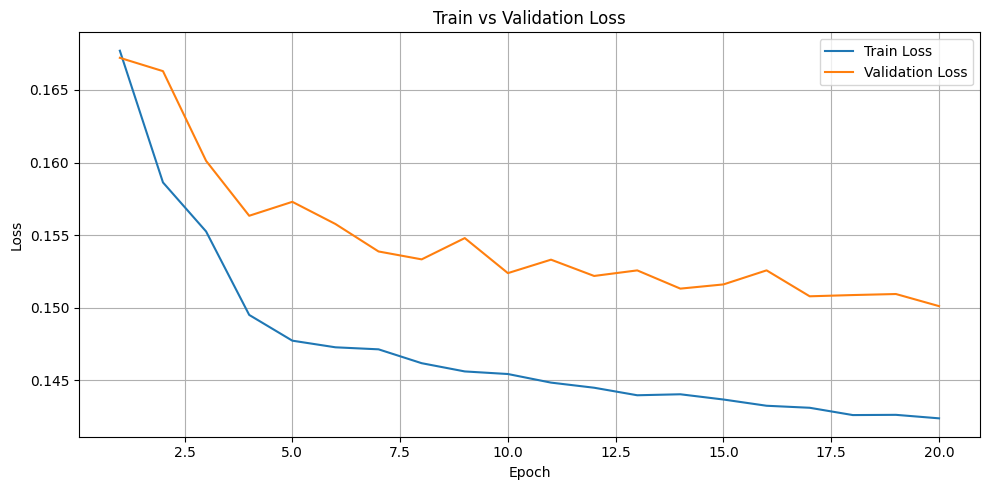

In [6]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv("data1day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)
df['performance_issue'] = (df['AVG_PROCESSING_TIME_MINUTES'] > 10).astype(int)
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# Define features and normalize
features = ['CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT']
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'performance_issue'
scaler = MinMaxScaler()
df[features + [target_reg]] = scaler.fit_transform(df[features + [target_reg]])

# Create sequences
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# Dataset and dataloaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# Define model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 20
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()
    train_losses.append(train_loss_epoch / len(train_loader))

    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls = model(xb)
            loss = criterion_reg(out_reg.squeeze(), yb_reg) + criterion_cls(out_cls.squeeze(), yb_cls)
            val_loss_epoch += loss.item()
    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
